# The prediction about None-Bayes SegNet with MaSTr1325

## Training Loss in 200 epochs
![avater](result/training/loss_segnet_1_MaSTr1325_200.jpg)

# Validation Metrics
|Metrics|Formula|Hint|
|:--|:--|:--|
|$\text{IOU}$          |$=\frac{\text{TP}}{\text{TP}+\text{FP}+\text{FN}}$|Area of Intersection / Area of Union|
|$\text{Dice-Sørensen}$|$=\frac{2\cdot\text{TP}}{\text{TP}+\text{FP}+\text{FN}}$| |
|$\text{Precision}$    |$=\frac{\text{TP}}{\text{TP}+\text{FP}}$|*Symbol*: $\text{Pr}$|
|$\text{Recall}$    |$=\frac{\text{TP}}{\text{TP}+\text{FN}}$|*Symbol*: $\text{Re}$|
|$\text{F1}$    |$=\frac{2\cdot\text{Pr}\cdot\text{Re}}{\text{Pr}+\text{Re}}$|Harmonic Mean of Precision and Recall|


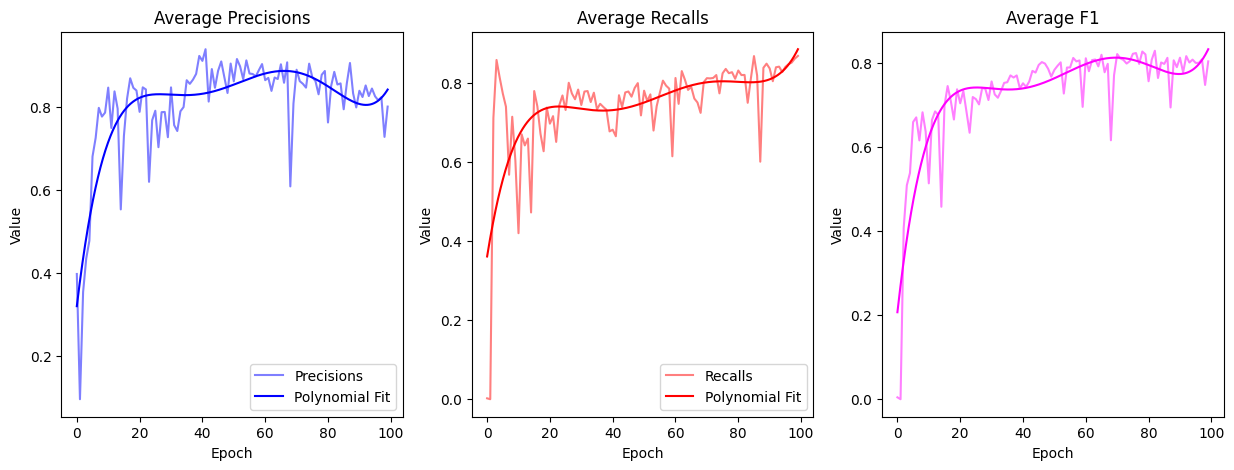

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

def evaluation_show(data):
        aver_iou = np.array([item['aver_iou'] for item in data])
        aver_dice = np.array([item['aver_dice'] for item in data])
        Prs = np.array([item['Prs'] for item in data])
        Res = np.array([item['Res'] for item in data])
        F1 = np.array([item['F1'] for item in data])
        
        # Polynomial Smoothing
        x = np.arange(len(data))
        Prs_sm = np.poly1d(np.polyfit(x, Prs, 5))
        Res_sm = np.poly1d(np.polyfit(x, Res, 5))
        F1_sm = np.poly1d(np.polyfit(x, F1, 5))
        x_sm = np.linspace(x.min(), x.max(), 10*len(data))
        Prs_sm = Prs_sm(x_sm)
        Res_sm = Res_sm(x_sm)
        F1_sm = F1_sm(x_sm)

        # # Plot figure 1 for iou and dice
        # plt.figure(figsize=(10, 5))
        # # plot average iou
        # plt.subplot(1, 2, 1)
        # plt.plot(aver_iou, label='mean IOU', color='red')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.title('IOU (Intersection Over Union)')
        # plt.legend()
        # # plot average dice
        # plt.subplot(1, 2, 2)
        # plt.plot(aver_dice, label='mean Dice', color='red')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.title('Dice-Sørensen Coeffeciency')
        # plt.show()

        # Plot figure 2 for precision / recalls / F1
        plt.figure(figsize=(15, 5))
        # plot average precision
        plt.subplot(1, 3, 1)
        plt.plot(Prs, label='Precisions', color='blue', alpha = 0.5)
        plt.plot(x_sm, Prs_sm, label='Polynomial Fit', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Average Precisions')
        plt.legend()
        # plot average recall
        plt.subplot(1, 3, 2)
        plt.plot(Res, label='Recalls', color='red', alpha = 0.5)
        plt.plot(x_sm, Res_sm, label='Polynomial Fit', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Average Recalls')
        plt.legend()
        # plot average F1
        plt.subplot(1, 3, 3)
        plt.plot(F1, label='F1', color='#FF00FF', alpha = 0.5)
        plt.plot(x_sm, F1_sm, label='Polynomial Fit', color='#FF00FF')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Average F1')
        plt.show()

# with open('result/validation-epoch200.json', 'r') as file:
with open('result/average2.json', 'r') as file:
        data = json.load(file)
evaluation_show(data)


# Testing Result
![avater](./result/testing/001.png)